In [ ]:
!pip install matplotlib
!pip install seaborn

In [ ]:
#from airflow.providers.postgres.hooks.postgres import PostgresHook
from sqlalchemy import create_engine, select, text
from sqlalchemy.orm import Session
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#from dags.module.info.connections import Connections

#import sys
#import os

# module_path = '/home/ubuntu/MLOps-project'
# if module_path not in sys.path:
#     sys.path.append(module_path)


In [ ]:
# PostgreSQL 연결 정보를 환경 변수에서 가져옵니다.
#postgres_hook = PostgresHook(postgres_conn_id=Connections.POSTGRES_DEFAULT.value)
# 데이터베이스 연결 엔진을 생성합니다.
engine = create_engine('postgresql://postgres:@:5432')


In [ ]:
# 세션을 생성하여 데이터베이스 연결
with Session(bind=engine) as session:
    query = text("SELECT * FROM btc_ohlc")
    
    # 쿼리 실행 및 결과를 pandas 데이터프레임으로 변환
    result = session.execute(query)
    df = pd.DataFrame(result.all(), columns=result.keys())
    session.commit()

In [ ]:
df.head(20)

In [ ]:
df.tail()

In [ ]:
df.info()     # non-null한 데이터. time 제외하고 int타입

In [ ]:
df.isnull().sum() 

In [ ]:
df.describe()  # open,high,low,close 중에 0인 값이 있거나, 이상치로 느껴지는 부분은 없는 것 같다. volume 분포 확인필요

In [ ]:
# volume = 0 인 데이터 호출
df[df['volume'] == 0]  # 3개의 데이터 발견.

In [ ]:
df[df['volume'] > 2000].value_counts()

In [ ]:
# time 컬럼이 오름차순으로 정렬되어 있는지 확인 (오름차순 : True, 아니면 : False)
is_sorted = df['time'].is_monotonic_increasing
is_sorted # True

In [ ]:
# 시계열 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.legend()
plt.show()

In [ ]:
# 시계열 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['volume'], label='Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Bitcoin Volume Over Time')
plt.legend()
plt.show()

In [ ]:
# 히스토그램을 통한 데이터 분포 시각화(volume)  -> skewed 
df.hist('volume', bins=100, figsize=(10, 10))
plt.show()

In [ ]:
#  가격 변동성 분석
df['price_diff'] = df['high'] - df['low']
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

In [ ]:
# 일일 변동폭 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['price_diff'], label='Daily Price Range (High - Low)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.title('Daily Price Range')
plt.legend()
plt.show()

In [ ]:
# 일일 로그 수익률 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['log_return'], label='Daily Log Return')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Daily Log Return')
plt.legend()
plt.show()


In [ ]:
df.isnull().sum()

In [ ]:
df[df['log_return'].isnull()] # 로그 수익률을 만들 때 shift(1) 을 하기 때문에 첫 행에서 nan값 발생.

In [ ]:
#  거래량과 가격의 관계 분석
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['volume'], y=df['close'])
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.title('Volume vs. Close Price')
plt.show()

In [ ]:
# 상관관계 계산
correlation = df[['volume', 'close', 'price_diff', 'log_return']].corr()
print("Correlation Matrix:")
print(correlation)

# 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# 박스플롯을 통한 이상치 확인 (volume)
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[['volume']])
plt.title('Boxplot of volume')
plt.show()


In [ ]:
df.head()

In [ ]:
'''
eda 결과
전체적으로 결측치는 존재하지 않았고, 시간순으로 잘 정렬되어있다.
거래량과 가격의 상관관계는 크지 않았다. 
volume 컬럼에서 0인 데이터가 3개 발견되었고 이 부분은 삭제하기 보다는 누락되는 시간이 없도록 하기 위해 선형보간법으로 채워줄 예정
volume 컬럼에서 이상치라고 할 수 있는 큰 값들이 존재하긴 하지만 많지 않고, 거래량은 비트코인 특성상 큰 값도 유의미하다고 생각해서
삭제까진 하지 않고,  유지하고 스케일링만 할 예정
가격 변동성을 확인할 수 있는 컬럼을 추가해서 확인해 보았다.
일일 가격 변동폭 : df['price_diff'] = df['high'] - df['low']
일일 로그수익률 : df['log_return'] = np.log(df['close'] / df['close'].shift(1))
여기서 로그수익률 컬럼을 만드는 과정에서 첫번째 인덱스에 nan값이 들어감.
scatterplot 확인결과 대부분의 거래가 거래량이 낮은 거래량(1000이하)에서 이루어지고 있음.
3000 이상을 이상치로 판단하면 될것 같다.


전처리 단계에서 할 일

1. volume = 0 인 컬럼 선형보간법 적용하기
2. volume > 3000 이상인 값은 3000으로 일괄 적용한 후 로그스케일링 적용하기
3. 'price_diff', 'log_return' 컬럼 추가하기
4. time 컬럼은 year, month, day, hour, 등의 피쳐로 나눠서 시간의 주기성을 반영하기 위해 
시간을 24시간을 주기로 사인과 코사인 변환하여 시간대 정보를 캡쳐
'''

In [ ]:
# 박스플롯을 통한 이상치 확인 (volume)
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[['volume']])
plt.title('Boxplot of volume')
plt.show()

In [ ]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import Session
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# PostgreSQL 연결 정보를 환경 변수에서 가져온다.
# 데이터베이스 연결 엔진을 생성한다.
engine = create_engine('postgresql://postgres:@:5432')

# 세션을 생성하여 데이터베이스 연결
with Session(bind=engine) as session:
    query = text("SELECT * FROM btc_ohlc")

    # 쿼리 실행 및 결과를 pandas 데이터프레임으로 변환
    result = session.execute(query)
    df = pd.DataFrame(result.all(), columns=result.keys())
    session.commit()

# 데이터 확인
print(df.head())
print(df.tail())
print(df.info())     
print(df.isnull().sum())
print(df.describe())

# volume = 0 인 데이터 호출
print(df[df['volume'] == 0])  

# time 컬럼이 오름차순으로 정렬되어 있는지 확인
is_sorted = df['time'].is_monotonic_increasing
print(is_sorted) 

# 시계열 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.legend()
plt.show()

# 시계열 데이터 시각화 (Volume)
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['volume'], label='Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Bitcoin Volume Over Time')
plt.legend()
plt.show()

# 히스토그램을 통한 데이터 분포 시각화(volume)
df.hist('volume', bins=100, figsize=(10, 10))
plt.show()

# 가격 변동성 분석
df['price_diff'] = df['high'] - df['low']
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 일일 변동폭 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['price_diff'], label='Daily Price Range (High - Low)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.title('Daily Price Range')
plt.legend()
plt.show()

# 일일 로그 수익률 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['log_return'], label='Daily Log Return')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Daily Log Return')
plt.legend()
plt.show()

# 거래량과 가격의 관계 분석
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['volume'], y=df['close'])
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.title('Volume vs. Close Price')
plt.show()

# 상관관계 계산
correlation = df[['volume', 'close', 'price_diff', 'log_return']].corr()
print("Correlation Matrix:")
print(correlation)

# 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 박스플롯을 통한 이상치 확인 (volume)
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[['volume']])
plt.title('Boxplot of volume')
plt.show()

# 전처리 단계

# 1. volume = 0 인 컬럼 선형보간법 적용하기
df['volume'] = df['volume'].replace(0, np.nan)
df['volume'] = df['volume'].interpolate()

# 2. volume > 3000 이상인 값은 3000으로 일괄 적용한 후 로그스케일링 적용하기
df['volume'] = df['volume'].apply(lambda x: 3000 if x > 3000 else x)
df['log_volume'] = np.log(df['volume'] + 1)  # 로그 변환 시 0이 되는 것을 방지하기 위해 +1을 더함

# 3. 'price_diff', 'log_return' 컬럼 추가하기
df['price_diff'] = df['high'] - df['low']
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 4. time 컬럼은 year, month, day, hour, 등의 피쳐로 나눠서 시간의 주기성을 반영하기 위해
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour

# 시간 정보를 캡쳐하기 위해 사인과 코사인 변환
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

print(df.head())

print("end")

In [ ]:
df

In [ ]:
'''
추세 분석 (Trend Analysis)
•	시계열 데이터의 장기적인 추세를 확인
•	이동 평균 (Moving Average)을 사용하여 추세를 부드럽게 함
'''
# 이동 평균 계산
df['moving_average_30'] = df['close'].rolling(window=30).mean()

# 시계열 데이터 시각화 (Moving Average)
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Close Price')
plt.plot(df['time'], df['moving_average_30'], label='30-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price with Moving Average')
plt.legend()
plt.show()
'''
그래프에서 원본 종가 데이터는 빠르고 큰 변동을 보여주며, 이는 비트코인의 높은 변동성을 반영한다.

30일 이동 평균의 이유
1.	단기 및 중기 추세 파악:
    •	단기 및 중기 추세를 파악하는 데 유용
    •	시장의 단기적인 변화를 이해하는 데 도움을 줌
2.	일반적인 관행:
    •	30일 이동 평균은 주식, 암호화폐 등 다양한 자산에서 많이 사용되는 일반적인 기준
    •	많은 투자자와 분석가들이 사용하는 표준

다른 이동 평균 기간
1.	7일 이동 평균:
	•	단기 추세 파악: 일주일 간의 단기적인 가격 변동을 분석할 때 유용
	•	변동성 확인: 단기적인 변동성을 더 민감하게 반영

단기(7일, 14일), 중기(30일, 50일), 장기(100일, 200일) 이동 평균을 함께 사용하면 데이터의 여러 측면을 분석할 수 있다.
각 기간은 다른 종류의 추세를 강조하며, 이를 통해 더 균형 잡힌 분석을 할 수 있다. 
시장의 변동성이 높을 때는 단기 이동 평균이 유용하다. 
'''

In [ ]:
# 이동 평균 계산
df['moving_average_7'] = df['close'].rolling(window=7).mean()
df['moving_average_30'] = df['close'].rolling(window=30).mean()
df['moving_average_50'] = df['close'].rolling(window=50).mean()
df['moving_average_100'] = df['close'].rolling(window=100).mean()
df['moving_average_200'] = df['close'].rolling(window=200).mean()

# 시계열 데이터 시각화 (다양한 이동 평균)
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Close Price')
plt.plot(df['time'], df['moving_average_7'], label='7-day Moving Average', color='green')
plt.plot(df['time'], df['moving_average_30'], label='30-day Moving Average', color='orange')
plt.plot(df['time'], df['moving_average_50'], label='50-day Moving Average', color='red')
plt.plot(df['time'], df['moving_average_100'], label='100-day Moving Average', color='purple')
plt.plot(df['time'], df['moving_average_200'], label='200-day Moving Average', color='brown')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price with Various Moving Averages')
plt.legend()
plt.show()

In [ ]:
df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 이동 평균 계산
df['moving_average_7'] = df['close'].rolling(window=7).mean()
df['moving_average_30'] = df['close'].rolling(window=30).mean()
df['moving_average_50'] = df['close'].rolling(window=50).mean()
df['moving_average_100'] = df['close'].rolling(window=100).mean()
df['moving_average_200'] = df['close'].rolling(window=200).mean()

# 결측치 제거 (이동 평균 계산으로 인해 생긴 NaN 값)
df.dropna(inplace=True)

# 피처와 타겟 변수 정의
features = ['open', 'high', 'low', 'volume', 'moving_average_7', 'moving_average_30', 'moving_average_50', 'moving_average_100', 'moving_average_200']
target = 'close'

X = df[features]
y = df[target]

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# 피처 중요도 시각화
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
y_pred

In [ ]:
df

In [ ]:
# MACD

In [ ]:
'''
계절성 분석 (Seasonality Analysis)
•	데이터의 계절적 패턴을 분석
•	특정 시간, 월, 계절에 따라 변동하는 패턴을 찾는다.
'''

# 월별 평균 가격 계산
df['month'] = df['time'].dt.month
monthly_avg = df.groupby('month')['close'].mean()

# 월별 평균 가격 시각화
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.title('Monthly Average Close Price')
plt.show()

In [ ]:
!pip install statsmodels

In [ ]:
'''
잔차 분석 (Residual Analysis)
•	추세와 계절성을 제거한 후 남은 잔차를 분석
•	ARIMA 모델을 사용하여 예측하고 잔차를 분석할 수 있다.
'''

from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열 분해
decomposition = seasonal_decompose(df['close'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# 시각화
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend') # 추세
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality') # 계절성
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals') # 잔차
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# 추세는 장기적인 방향성을 보여주며, 계절성은 주기적인 변동을 나타낸다. 잔차는 나머지 부분을 포함한다.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 시계열 분해
decomposition = seasonal_decompose(df['close'], model='additive', period=365)
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal
df['residual'] = decomposition.resid

# 결측치 제거 (시계열 분해로 인해 생긴 NaN 값)
df.dropna(inplace=True)

# 이동 평균 계산
df['moving_average_7'] = df['close'].rolling(window=7).mean()
df['moving_average_30'] = df['close'].rolling(window=30).mean()
df['moving_average_50'] = df['close'].rolling(window=50).mean()
df['moving_average_100'] = df['close'].rolling(window=100).mean()
df['moving_average_200'] = df['close'].rolling(window=200).mean()

# 결측치 제거 (이동 평균 계산으로 인해 생긴 NaN 값)
df.dropna(inplace=True)

# 피처와 타겟 변수 정의
features = ['open', 'high', 'low', 'volume', 'moving_average_7', 'moving_average_30', 'moving_average_50', 
            'moving_average_100', 'moving_average_200', 'trend', 'seasonal', 'residual']
target = 'close'

X = df[features]
y = df[target]

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# 피처 중요도 시각화
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
'''
변동성 분석 (Volatility Analysis)
•	데이터의 변동성을 분석하여 안정성을 평가
•	일일 수익률의 표준 편차를 계산
'''

# 일일 수익률의 표준 편차 계산
volatility = df['log_return'].std()

print("Daily Log Return Volatility:", volatility)

# 변동성 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['log_return'].rolling(window=30).std(), label='30-day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Bitcoin Rolling Volatility')
plt.legend()
plt.show()
'''
•	로그 수익률의 표준 편차를 계산하여 일일 변동성을 측정함
•	변동성은 가격 변동의 크기를 나타내며, 높은 변동성은 리스크가 높음을 의미한다.
•	30일 이동 표준 편차를 사용하여 변동성의 변화를 시각화했다.
'''

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 로그 리턴 계산
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 변동성 계산 (30일 이동 표준 편차)
df['volatility_30'] = df['log_return'].rolling(window=30).std()

# 결측치 제거 (로그 리턴과 변동성 계산으로 인해 생긴 NaN 값)
df.dropna(inplace=True)

# 이동 평균 계산
df['moving_average_7'] = df['close'].rolling(window=7).mean()
df['moving_average_30'] = df['close'].rolling(window=30).mean()
df['moving_average_50'] = df['close'].rolling(window=50).mean()
df['moving_average_100'] = df['close'].rolling(window=100).mean()
df['moving_average_200'] = df['close'].rolling(window=200).mean()

# 결측치 제거 (이동 평균 계산으로 인해 생긴 NaN 값)
df.dropna(inplace=True)

# 피처와 타겟 변수 정의
features = ['open', 'high', 'low', 'volume', 'moving_average_7', 'moving_average_30', 'moving_average_50', 
            'moving_average_100', 'moving_average_200', 'log_return', 'volatility_30']
target = 'close'

X = df[features]
y = df[target]

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# 피처 중요도 시각화
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
'''
이상치 탐지 (Outlier Detection)
•	비정상적인 데이터 포인트를 탐지하고 제거
•	IQR (Interquartile Range) 방법을 사용
'''

# IQR을 사용한 이상치 탐지
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['close'] < (Q1 - 1.5 * IQR)) | (df['close'] > (Q3 + 1.5 * IQR))]

print("Outliers detected:")
print(outliers)
'''
이상치가 발견되지 않았다.
'''

In [ ]:
'''
자기상관 분석 (Autocorrelation Analysis)
•	데이터의 자기상관성을 분석하여 패턴을 찾는다.
•	ACF (Autocorrelation Function)와 PACF (Partial Autocorrelation Function)를 사용
'''

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF와 PACF 시각화
plt.figure(figsize=(14, 7))
plot_acf(df['log_return'].dropna(), lags=50)
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(df['log_return'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sqlalchemy import create_engine, select, text
from sqlalchemy.orm import Session
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

engine = create_engine('postgresql://postgres:@:5432')

# 세션을 생성하여 데이터베이스 연결
with Session(bind=engine) as session:
    query = text("SELECT * FROM btc_ohlc")
    
    # 쿼리 실행 및 결과를 pandas 데이터프레임으로 변환
    result = session.execute(query)
    df = pd.DataFrame(result.all(), columns=result.keys())
    session.commit()

In [5]:
df

,time,open,high,low,close,volume
0,2023-05-28 12:00:00,36171000,36320000,36165000,36270000,257
1,2023-05-28 13:00:00,36280000,36421000,36270000,36314000,192
2,2023-05-28 14:00:00,36314000,36318000,36218000,36246000,116
3,2023-05-28 15:00:00,36246000,36355000,36246000,36318000,103
4,2023-05-28 16:00:00,36298000,36380000,36298000,36355000,80
...,...,...,...,...,...,...
8808,2024-05-29 12:00:00,95058000,95200000,95001000,95199000,15
8809,2024-05-29 13:00:00,95070000,95129000,95020000,95041000,9
8810,2024-05-29 14:00:00,95054000,95055000,94712000,94842000,57
8811,2024-05-29 15:00:00,94747000,94760000,94718000,94719000,11


Mean Squared Error: 22169747482.716965
R2:  0.999956418065787


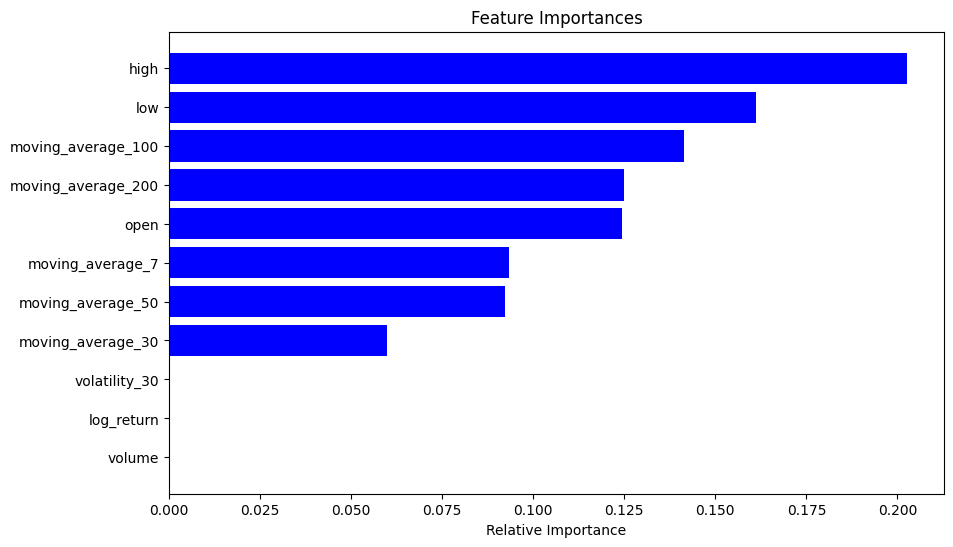

In [9]:
# 로그 리턴 계산
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 변동성 계산 (30일 이동 표준 편차)
df['volatility_30'] = df['log_return'].rolling(window=30).std()

# 이동 평균 계산
df['moving_average_7'] = df['close'].rolling(window=7).mean()
df['moving_average_30'] = df['close'].rolling(window=30).mean()
df['moving_average_50'] = df['close'].rolling(window=50).mean()
df['moving_average_100'] = df['close'].rolling(window=100).mean()
df['moving_average_200'] = df['close'].rolling(window=200).mean()

# 결측치 제거 (이동 평균 계산으로 인해 생긴 NaN 값)
df.dropna(inplace=True)

# 피처와 타겟 변수 정의
features = ['open', 'high', 'low', 'volume', 'moving_average_7', 'moving_average_30', 'moving_average_50', 
            'moving_average_100', 'moving_average_200', 'log_return', 'volatility_30']
target = 'close'

X = df[features]
y = df[target]

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2: ", r2)

# 피처 중요도 시각화
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# R2 스코어를 사용하여 교차 검증
# R2 스코어를 사용한 교차 검증을 통해 모델의 일반화 성능을 평가할 수 있다.
scorer = make_scorer(r2_score)
scores = cross_val_score(model, X, y, scoring=scorer, cv=5)

print("교차 검증 R2 스코어:", scores)
print("평균 R2 스코어:", scores.mean())

교차 검증 R2 스코어: [0.86438931 0.99305209 0.95651985 0.96802381 0.99069184]
평균 R2 스코어: 0.9545353801116854


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 예측값 계산
y_pred = model.predict(X_test)

# 성능 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
# 이 값들은 모델의 예측값과 실제값 사이의 절대적인 차이를 나타낸다. 
# RMSE가 큰 값일수록, 그리고 MAE가 큰 값일수록 모델의 예측이 실제 데이터와 많이 차이가 나는 것을 의미한다.

RMSE: 148895.08884686884
MAE: 78196.7680839416


/home/ubuntu/MLOps-project/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 개선점
    - 모델을 고도화한다.
    - 다른 알고리즘을 시도한다: 앙상블 방법(랜덤 포레스트, 그래디언트 부스팅 등)
    - 데이터 전처리를 더 세밀하게 수행한다. 
        - outlier를 제거하거나 변환을 적용
    - 특성 공학 적용
        - 더 나은 특성(feature)을 생성하여 모델에 제공
    - 평가 방법 개선

In [12]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 13.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.5 MB/s eta 0:00:0000:0100:01


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sqlalchemy import create_engine, select, text
from sqlalchemy.orm import Session
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

engine = create_engine('postgresql://postgres:@:5432')

# 세션을 생성하여 데이터베이스 연결
with Session(bind=engine) as session:
    query = text("SELECT * FROM btc_ohlc")
    
    # 쿼리 실행 및 결과를 pandas 데이터프레임으로 변환
    result = session.execute(query)
    df = pd.DataFrame(result.all(), columns=result.keys())
    session.commit()

# 로그 리턴 계산
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# 변동성 계산 (30일 이동 표준 편차)
df['volatility_30'] = df['log_return'].rolling(window=30).std()

# 이동 평균 계산
df['moving_average_7'] = df['close'].rolling(window=7).mean()
df['moving_average_30'] = df['close'].rolling(window=30).mean()
df['moving_average_50'] = df['close'].rolling(window=50).mean()
df['moving_average_100'] = df['close'].rolling(window=100).mean()
df['moving_average_200'] = df['close'].rolling(window=200).mean()

# 결측치 제거 (이동 평균 계산으로 인해 생긴 NaN 값)
df.dropna(inplace=True)

# 피처와 타겟 변수 정의
features = ['open', 'high', 'low', 'volume', 'moving_average_7', 'moving_average_30', 'moving_average_50', 
            'moving_average_100', 'moving_average_200', 'log_return', 'volatility_30']
target = 'close'

X = df[features]
y = df[target]

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, silent=True, random_seed=42)
# model.fit(X_train, y_train)

# # 예측
# y_pred = model.predict(X_test)

# # 평가
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print("Mean Squared Error:", mse)
# print("R2: ", r2)

# # 피처 중요도 시각화
# feature_importances = model.feature_importances_
# indices = np.argsort(feature_importances)

# plt.figure(figsize=(10, 6))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

# 교차 검증 R2 스코어 계산
cv_scores = cross_val_score(model, X, y, scoring='r2', cv=5)

print("CatBoost 교차 검증 R2 스코어:", cv_scores)
print("평균 R2 스코어:", cv_scores.mean())

# 모델 학습
model.fit(X, y)

# 예측값 계산
y_pred = model.predict(X)

# 성능 지표 계산
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, root_mean_squared_error=False)
mae = mean_absolute_error(y, y_pred)

print("R2 스코어:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

CatBoost 교차 검증 R2 스코어: [0.92608319 0.96649797 0.74671386 0.79983196 0.9479903 ]
평균 R2 스코어: 0.8774234566891332
R2 스코어: 0.9999803818327184
RMSE: 101588.14564049806
MAE: 70008.76659491319


/home/ubuntu/MLOps-project/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
engine = create_engine('postgresql://postgres:@:5432')

# 세션을 생성하여 데이터베이스 연결
with Session(bind=engine) as session:
    query = text("SELECT * FROM btc_ohlc")
    
    # 쿼리 실행 및 결과를 pandas 데이터프레임으로 변환
    result = session.execute(query)
    df = pd.DataFrame(result.all(), columns=result.keys())
    session.commit()